# Kwame's Zillow Zestimates Error Control

Table of contents with header links goes here.

## explore.ipynb

### When this section of the pipeline is done being coded, I will transfer internal code to ```explore.py``` and external code and output to the final notebook.

**I may make this the final notebook with a rename and cleanup.**

### Set up the environment

In [47]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# import necessary packages/modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from math import sqrt

from wrangle import get_zillow_data, prepare_zillow
from preprocessing import zillow_main_split, zillow_Xy_split, impute_nulls, zillow_scale
from explore import viz_logerror, corr_heatmap, ttest_viz, ttest_hypo

# default viz size settings
plt.rc('figure', figsize=(9, 7))
plt.rc('font', size=13)

# default pandas decimal number display format
#pd.options.display.float_format = '{:20,.2f}'.format

### Acquire the data

In [2]:
df = get_zillow_data()
df.shape

(77580, 69)

### Tidy the data

In [3]:
df = prepare_zillow(df)
df.head(3)

,bathcnt,sqft,latitude,longitude,county,yearbuilt,value,logerror,bathbedcnt,decade,century
parcelid,,,,,,,,,,,
14297519,3.50,"3,100.00","33,634,931.00","-117,869,207.00",1,"1,998.00","1,023,282.00",0.03,7.50,199.00,19.00
17052889,1.00,"1,465.00","34,449,266.00","-119,281,531.00",2,"1,967.00","464,000.00",0.06,3.00,196.00,19.00
14186244,2.00,"1,243.00","33,886,168.00","-117,823,170.00",1,"1,962.00","564,778.00",0.01,5.00,196.00,19.00


### Summarize the clean data

In [4]:
df.shape

(52412, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52412 entries, 14297519 to 13083743
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bathcnt     52412 non-null  float64
 1   sqft        52330 non-null  float64
 2   latitude    52412 non-null  float64
 3   longitude   52412 non-null  float64
 4   county      52412 non-null  int64  
 5   yearbuilt   52296 non-null  float64
 6   value       52411 non-null  float64
 7   logerror    52412 non-null  float64
 8   bathbedcnt  52412 non-null  float64
 9   decade      52296 non-null  float64
 10  century     52296 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 4.8 MB


In [6]:
df.isnull().sum()

bathcnt         0
sqft           82
latitude        0
longitude       0
county          0
yearbuilt     116
value           1
logerror        0
bathbedcnt      0
decade        116
century       116
dtype: int64

The remaining nulls have to be imputed after the data split so that we aren't cheating with our data sets.

### Split the data into train, validate, test.

In [7]:
# main split
train, validate, test = zillow_main_split(df)

In [8]:
print(f'Shape of train data: {train.shape}')
print(f'Shape of validate data: {validate.shape}')
print(f'Shape of test data: {test.shape}')

Shape of train data: (29350, 11)
Shape of validate data: (12579, 11)
Shape of test data: (10483, 11)


### Impute the remaining nulls with medians.

In [9]:
train = impute_nulls(train)
train.isnull().sum()

bathcnt        0
sqft           0
latitude       0
longitude      0
county         0
yearbuilt      0
value          0
logerror       0
bathbedcnt     0
decade        69
century       69
dtype: int64

In [10]:
validate = impute_nulls(validate)
validate.isnull().sum()

bathcnt        0
sqft           0
latitude       0
longitude      0
county         0
yearbuilt      0
value          0
logerror       0
bathbedcnt     0
decade        27
century       27
dtype: int64

In [11]:
test = impute_nulls(test)
test.isnull().sum()

bathcnt        0
sqft           0
latitude       0
longitude      0
county         0
yearbuilt      0
value          0
logerror       0
bathbedcnt     0
decade        20
century       20
dtype: int64

### Split the data into X and y train, X and y validate, X and y test.

In [12]:
X_train, X_validate, X_test, y_train, y_validate, y_test = zillow_Xy_split(train, validate, test)

In [13]:
# checking to make sure data was split correctly
print(f'Shape of X train data: {X_train.shape}')
print(f'Shape of X validate data: {X_validate.shape}')
print(f'Shape of X test data: {X_test.shape}')
print('\n')
print(f'Shape of y train data: {y_train.shape}')
print(f'Shape of y validate data: {y_validate.shape}')
print(f'Shape of y test data: {y_test.shape}')

Shape of X train data: (29350, 10)
Shape of X validate data: (12579, 10)
Shape of X test data: (10483, 10)


Shape of y train data: (29350,)
Shape of y validate data: (12579,)
Shape of y test data: (10483,)


### Scale the data

In [14]:
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = zillow_scale(X_train, X_validate, X_test)
X_train_scaled.head(3)

,bathcnt,sqft,latitude,longitude,county,yearbuilt,value,bathbedcnt,decade,century
parcelid,,,,,,,,,,
10750905,0.31,0.13,0.53,0.36,0.00,0.84,0.03,0.38,0.86,0.50
13051572,0.23,0.11,0.53,0.91,0.00,0.69,0.01,0.33,0.71,0.50
11419247,0.08,0.03,0.39,0.58,0.00,0.50,0.01,0.14,0.50,0.50


### Explore the data and create visualizations

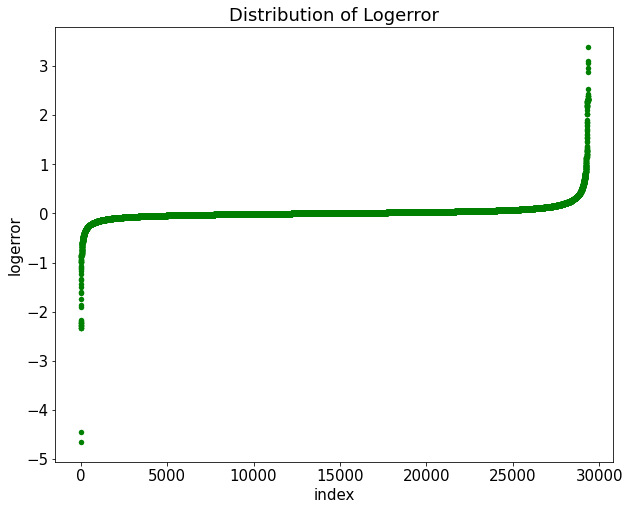

In [15]:
viz_logerror(train)

**There are outliers present, especially on the side of negative logerror. I will handle these on the next iteration of this section.**

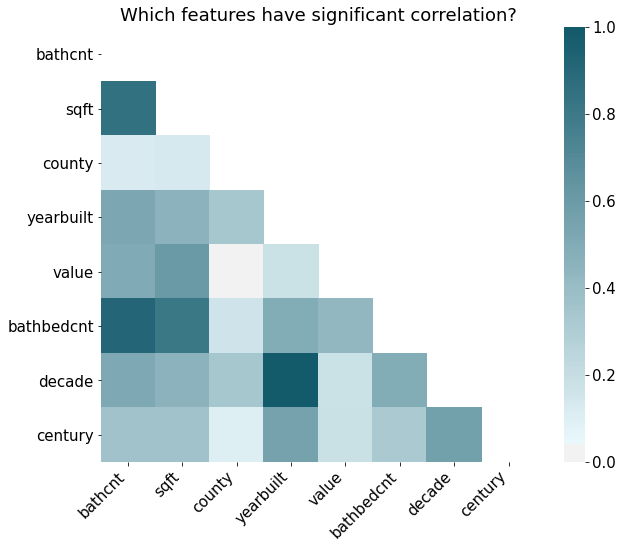

In [16]:
corr_heatmap(X_train_scaled)

(array([1.0000e+01, 2.3000e+01, 6.5900e+02, 1.9740e+03, 1.1060e+03,
        1.0375e+04, 4.6340e+03, 5.9000e+03, 2.1260e+03, 2.4740e+03]),
 array([187. , 188.4, 189.8, 191.2, 192.6, 194. , 195.4, 196.8, 198.2,
        199.6, 201. ]),
 <a list of 10 Patch objects>)

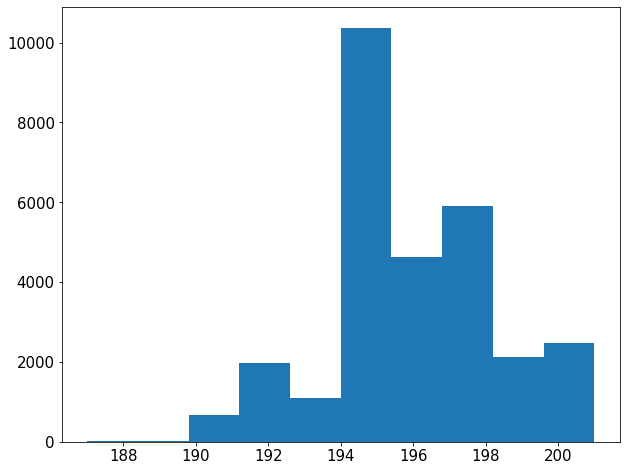

In [17]:
plt.hist(train.decade)

Text(0.5, 1.0, 'Which properties have more log error, by year built bins and county?')

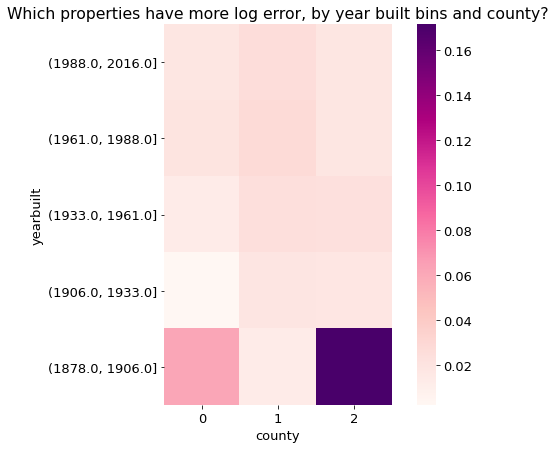

In [48]:
# pandas pivot
heatmap1_data = pd.pivot_table(train, values='logerror', 
                     index=pd.cut(train['yearbuilt'], bins=5, precision=0), 
                     columns='county')
heatmap1_data.sort_index(inplace=True, ascending=False)
sns.heatmap(heatmap1_data, cmap="RdPu", square=True)
plt.title('Which properties have more log error, by year built bins and county?')

'Los Angeles': 0,

'Orange': 1,

'Ventura': 2

Looks like properties built before 1906 have slightly more log error.

### One statistical test - 1 sample 2 tailed T-test: categorical vs cont.

In [19]:
#keep this in final notebook
train.century.value_counts()

19.00    26774
20.00     2474
18.00       33
Name: century, dtype: int64

## Is there a significant difference in the log error of Zestimates on properties built in the 1800s and the overall log error?

$
\begin{align*}
   H_0 & : \text{There is no difference in Zestimate log error in properties built in the 1800s and the overall log error.}
   \\
   H_a & : \text{There is a difference in Zestimate log error in properties built in the 1800s and the overall log error.}
   \\
    \alpha & : \text{0.05}
\end{align*}
$

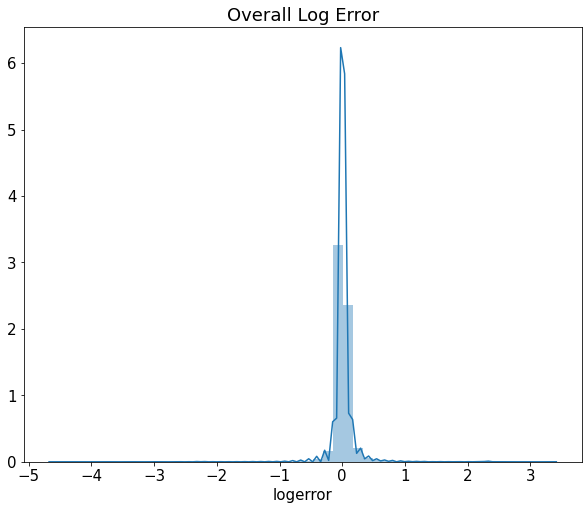

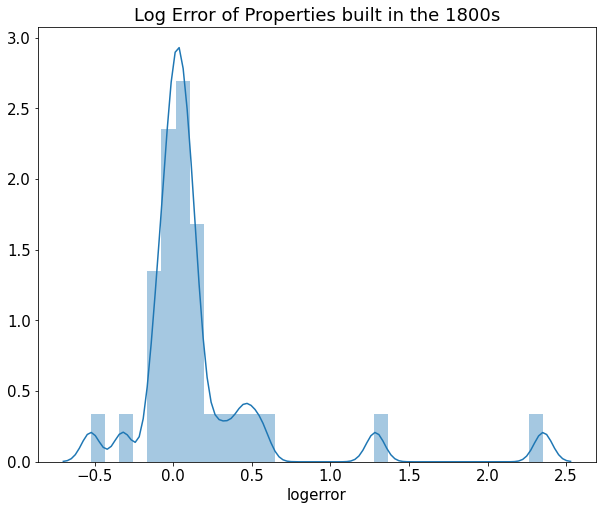

Compare the median and mean:
 0.018017412713940112 0.00706572454818


In [20]:
ttest_viz(train)

There are some outliers, but I will say that the mean and median are close enough for this iteration. I will remove outliers in the next iteration.

**Now that we know the variable has a normal distribution and we compared the mean and median, we can run the T-test.**

In [21]:
ttest_hypo(train)

t = 1.644
p = 0.110
We fail to reject the null hypothesis.


**There doesn't seem to be a statistically significant difference in log error in properties built in the 1800s and the overall log error.**

**However I do notice that the distribution of the log error of properties built in the 1800s is skewed differently from the overall log error.**

### Stats test 2:

In [30]:
train.columns

Index(['bathcnt', 'sqft', 'latitude', 'longitude', 'county', 'yearbuilt',
       'value', 'logerror', 'bathbedcnt', 'decade', 'century'],
      dtype='object')

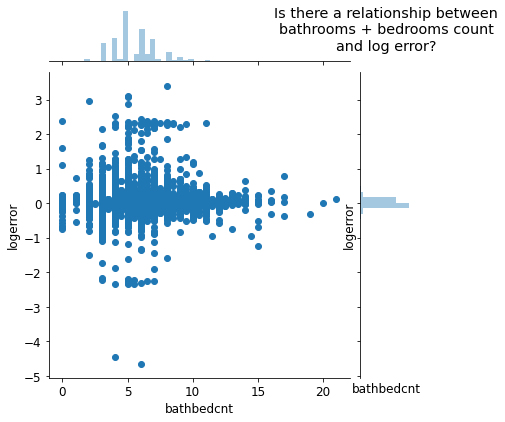

In [40]:
sns.jointplot(x="bathbedcnt", y="logerror", data=train)
plt.xlabel("bathbedcnt")
plt.ylabel("logerror")
plt.title("Is there a relationship between\nbathrooms + bedrooms count\nand log error?\n")
plt.show()

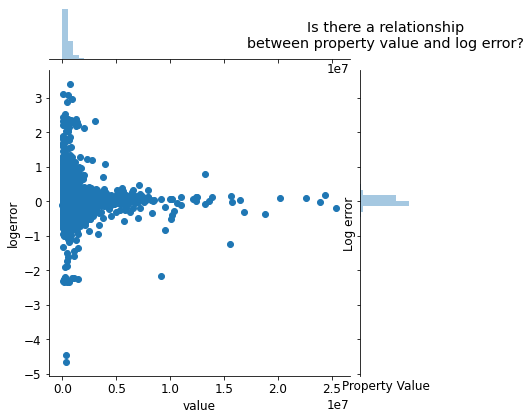

In [41]:
sns.jointplot(x="value", y="logerror", data=train)
plt.xlabel("Property Value")
plt.ylabel("Log error")
plt.title("Is there a relationship\nbetween property value and log error?\n")
plt.show()

It seems like there is definitely more error amongst lower value properties.

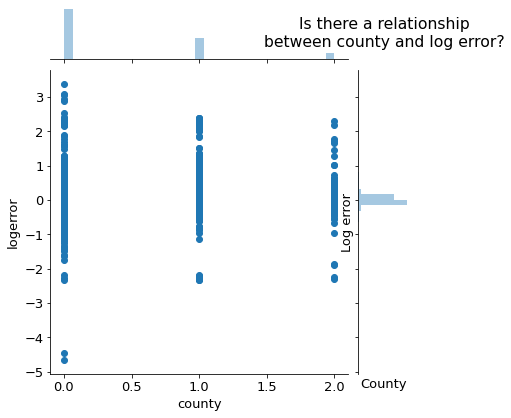

In [43]:
sns.jointplot(x="county", y="logerror", data=train)
plt.xlabel("County")
plt.ylabel("Log error")
plt.title("Is there a relationship\nbetween county and log error?\n")
plt.show()

More log error in Los Angeles county.

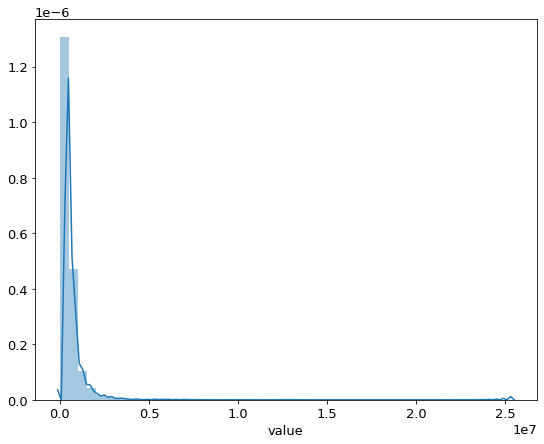

In [44]:
sns.distplot(train.value)

Looks normally distributed enough, so I can run a Pearson's R test on this. I will do that statistical testing in the next iteration through the pipeline.

### Next step in exploration: Study up on how to use clustering to make groups of like properties to target log error.

# Modeling

### Next step in modeling: Finish building a functioning MVP model, even if I don't totally understand how it works.